# Splitting trees for 'complex' CAZy families

In this notebook, I'll work up a pair of functions to split a dendrogram into *disjoint* subtrees on two criteria:

1. do not allow a subtree to contain paralogues (two sequences from the same organism)
2. do not allow a subtree to have a depth greater than some value

If either criterion is violated, the subtree in question is broken down into progressively smaller subtrees until a set of subtrees describing all original leaf nodes that do fit those criteria is obtained.

## Python imports

We use `re` to help identify paralogues by sequence ID, and `Bio.Phylo` to process the trees

In [1]:
import os
import re

from Bio import Phylo

We load an example tree (GH24 or GH19) with `Bio.Phylo`, and reroot it to a midpoint.

Here we are using a protein sequence-based tree constructed using sequence identity as a distance metric. This allows us to treat tree depth as a proxy for functional similarity (see [this paper](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000160)). That is not possible with many other ways to construct a tree.

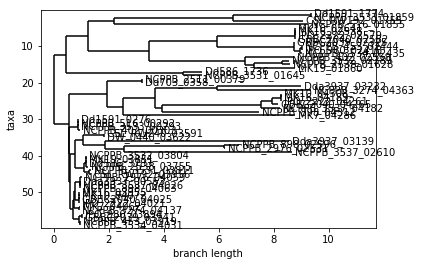

59


In [2]:
tree = Phylo.read("GH19.new", format="newick")
tree.root_at_midpoint()
Phylo.draw(tree)
print(len(tree.get_terminals()))

## 1. Split on absence of paralogues

Our first goal is to ensure that there are no repeated species in the tree. We can create a function to test for this:

In [3]:
species_pattern = re.compile("_[0-9]*$")

def has_paralogues(tree):
    """Returns True if the passed tree contains two or more paralogues.
    
    The identifiers for all leaves in the tree are processed with re
    to reduce them to only their organism identifier. The set() of these
    identifiers is nonredundant, so if it is the same length as the
    number of leaf nodes in the tree, there are no repeated organisms,
    and the tree contains no paralogues.
    """
    leaf_names = [re.split(species_pattern, e.name)[0] for e in tree.get_terminals()]
    return len(leaf_names) != len(set(leaf_names))

If the complete tree has no paralogues, there's no problem to be solved, so we wouldn't need to split the tree. With both of our example trees however, we do have paralogues:

In [4]:
has_paralogues(tree)

True

When we *do* have paralogues, we want to split the tree into the largest disjoint subtrees that do not contain any paralogues, but still include (collectively) all the sequences from the input tree.

In `Bio.Phylo` we need to work with 'clades' from the parent tree. We aim to identify the top-level clades (those just below the root) and determine if they contain paralogues. We write a function to test this:

In [5]:
def is_top_level(clade, tree):
    """Returns True if clade is top level in tree"""
    return len(tree.get_path(clade)) == 1

Now we check that our function works by drawing the top level clades from the input tree (and noting whether they have paralogues):

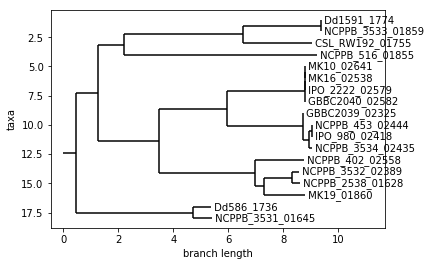

False


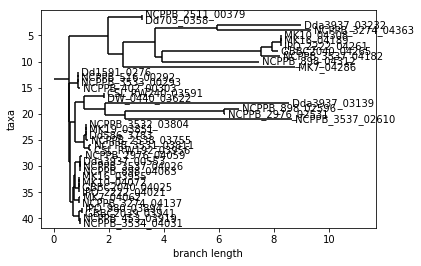

True


In [6]:
for clade in [c for c in tree.find_clades() if is_top_level(c, tree)]:
    subtree = Phylo.BaseTree.Tree(clade)
    Phylo.draw(subtree)
    print(has_paralogues(subtree))

This example works for a fairly straightforward tree, but would require that we visually inspect, and rerun functions in the cases where the top level subtrees don't split nicely into non-paralogue clades.

What we want is a single function that returns all the disjoint highest-level non-paralogue clades, given a single tree as input. Then we could call it something like what follows:

```python
for treefile in os.listdir('data/trees'):
    tree = Phylo.read(treefile, format="Newick")
    subtrees = split_trees(tree)
    for st in subtrees:
        Phylo.draw(st)
```

Firstly we need to write a function that splits the input tree into the disjoint subtrees with no paralogues. We write a *recursive function* to make this computationally straightforward. These kinds of functions are sometimes highly confusing to write and understand, so it's worth taking your time to understand what is going on, here:

In [7]:
def split_tree_noparalogues(tree, nplist=None):
    """Return a list of disjoint subtrees with no paralogues"""
    if nplist is None:  # Required to avoid state issues
        nplist = list()
    if not has_paralogues(tree):  # base case
        nplist.append(tree)
        return nplist
    else:  # recursive case
        for clade in [c for c in tree.find_clades()
                      if is_top_level(c, tree)]:
            subtree = Phylo.BaseTree.Tree(clade)
            split_tree_noparalogues(subtree, nplist)
    return nplist

Applying this function to our tree, we find all the disjoint subtrees:

Found 5 disjoint subtrees with no shared paralogues


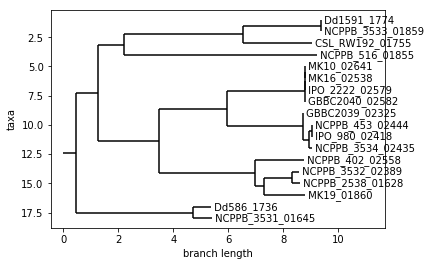

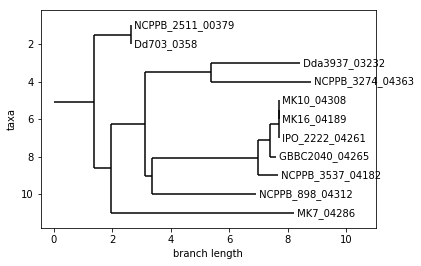

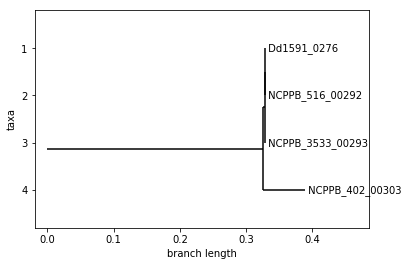

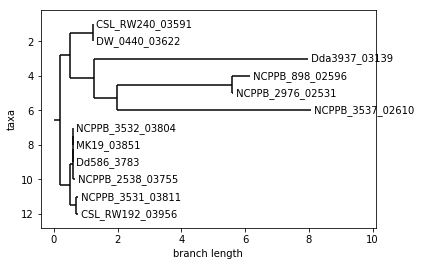

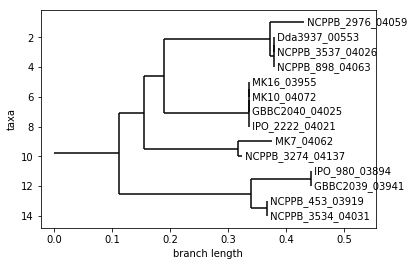

In [8]:
subtrees = split_tree_noparalogues(tree)
print("Found {} disjoint subtrees with no shared paralogues".format(len(subtrees)))
for t in subtrees:
    Phylo.draw(t)

## 2. Split on tree/subtree depth

Our next goal is to have no subtrees/trees whose longest branch length from root to tip is greater than some value. We can create a function to test for this in any given tree:

In [9]:
def is_shorter_than(tree, length):
    return max([tree.distance(t) for t in tree.get_terminals()]) < length

And we can test it:

In [10]:
is_shorter_than(tree, 20)

True

We can follow the same model for a recursive function that we used above, except now we halt recursion on the basis of subtree depth, rather than whether it contains paralogues.

In [11]:
def split_tree_depth(tree, branch_length=20, stlist=None):
    """Returns a list of subtrees with max len branch_length."""
    if stlist is None:  # Required to avoid problems with state
        stlist = list()
    if is_shorter_than(tree, branch_length):  # base case
        stlist.append(tree)
        return stlist
    else:  # recursive case
        for clade in [c for c in tree.find_clades() if is_top_level(c, tree)]:
            st = Phylo.BaseTree.Tree(clade)
            split_tree_depth(st, branch_length, stlist)
    return stlist

Testing this function on the complete tree:

Subtrees: 1


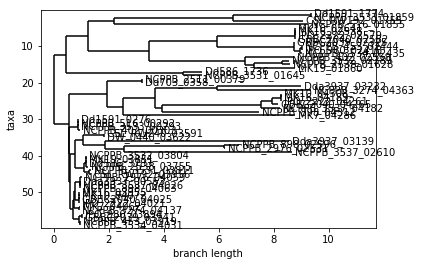

9.366409375


In [12]:
subtrees = split_tree_depth(tree)

print("Subtrees:", len(subtrees))
for subtree in subtrees:
    Phylo.draw(subtree)
    print(max([subtree.distance(t) for t in subtree.get_terminals()]))

## 3. Putting it together

We'd really like to split on paralogues (or lack of…) first, then split *those* subtrees by subtree length, to give subtrees that contain no paralogues *and* meet a minimum depth requiremend. To do this, we can apply the recursive functions in turn:

Number of subtrees, split on paralogues: 2
Number of subtrees, split on depth: 4


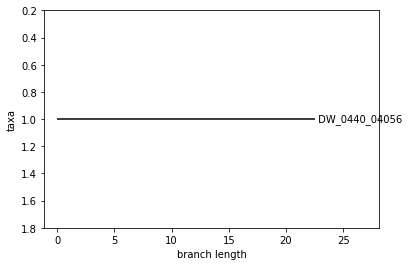

has paralogues?: False
short tree?: True


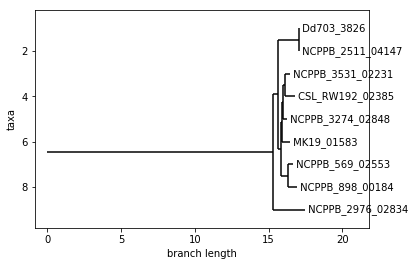

has paralogues?: False
short tree?: True


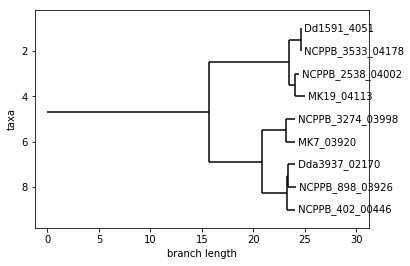

has paralogues?: False
short tree?: True


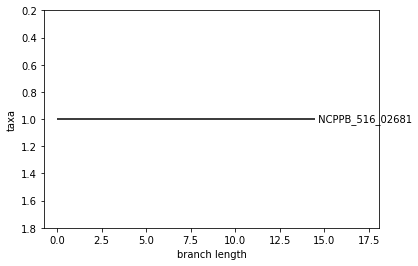

has paralogues?: False
short tree?: True


In [13]:
tree = Phylo.read("GH24.new", format="newick")
tree.root_at_midpoint()
paralogue_splits = split_tree_noparalogues(tree)
print("Number of subtrees, split on paralogues: {}".format(len(paralogue_splits)))
subtrees = []
for ps in paralogue_splits:
    subtrees.extend(split_tree_depth(ps))
print("Number of subtrees, split on depth: {}".format(len(subtrees)))

for st in subtrees:
    Phylo.draw(st)
    print("has paralogues?: {}".format(has_paralogues(st)))
    print("short tree?: {}".format(is_shorter_than(st, 20)))

This is all good, but to make it very reusable, we want to wrap the whole thing into a single function:

In [14]:
def split_tree(tree, branch_length=20):
    """Split tree into disjoint subtrees with maximum depth and
    containing no paralogues.
    """
    paralogue_splits = split_tree_noparalogues(tree)
    subtrees = []
    for ps in paralogue_splits:
        subtrees.extend(split_tree_depth(ps, branch_length))
    return subtrees

Now we can achieve the goal we had earlier:

Complete tree for GH19.new:


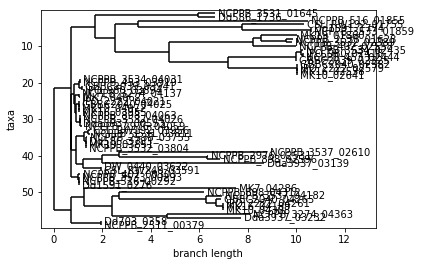

Subtrees (5)


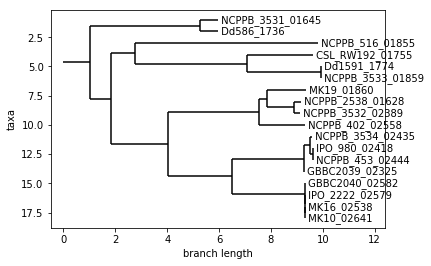

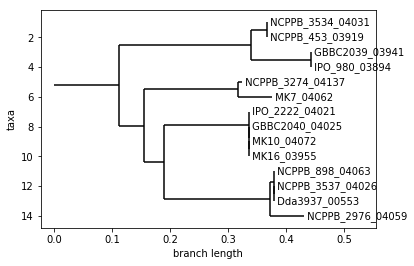

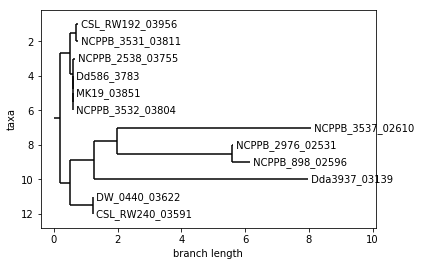

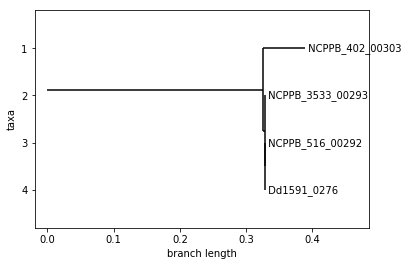

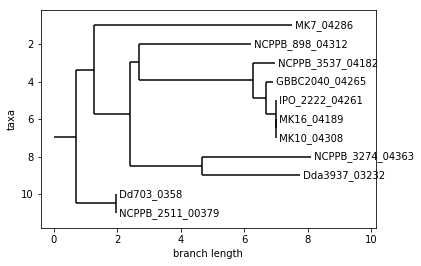

Complete tree for GH24.new:


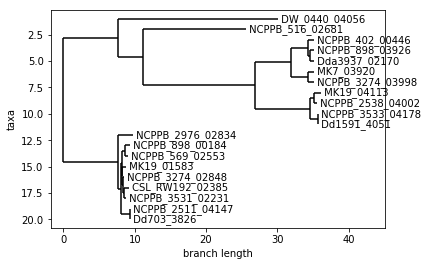

Subtrees (4)


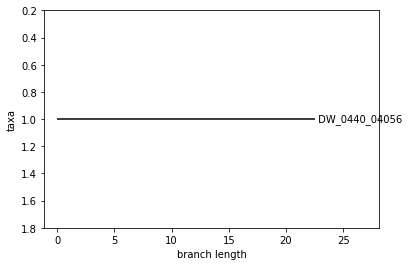

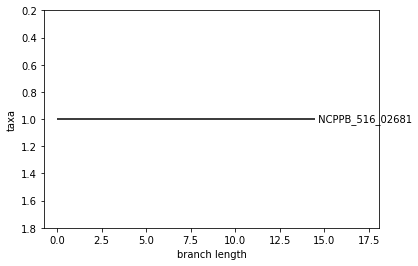

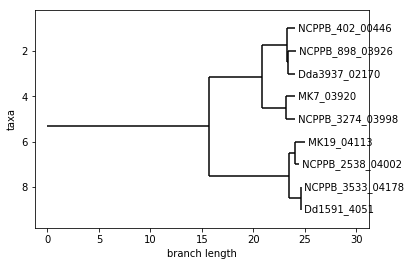

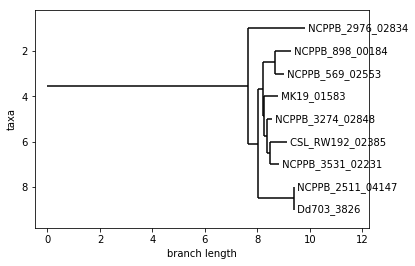

In [15]:
for treefile in [f for f in os.listdir('.') if
                 os.path.splitext(f)[-1] == '.new']:
    tree = Phylo.read(treefile, format="newick")
    print("Complete tree for {}:".format(treefile))
    Phylo.draw(tree)
    subtrees = split_tree(tree)
    print("Subtrees ({})".format(len(subtrees)))
    for st in subtrees:
        Phylo.draw(st)